In [1]:
!pip install imblearn joblib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, accuracy_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve,
                             precision_recall_curve, precision_score, recall_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib


### **File Import from PC**


In [2]:
from google.colab import files

uploaded = files.upload()

# Get uploaded filename
file_name = list(uploaded.keys())[0]

# Read Excel file
df = pd.read_excel(file_name)
df.head()


Saving osteoarthritis_dataset.xlsx to osteoarthritis_dataset.xlsx


,patient_id,age,sex,bmi,knee_side,cartilage_medial_mm,cartilage_lateral_mm,joint_space_medial_mm,joint_space_lateral_mm,osteophytes,...,cholesterol,hemoglobin,socioeconomic_status,exercise_frequency,smoking_status,alcohol_consumption,texture_entropy,texture_contrast,pain_catastrophizing,progression_2yr
0,1,78,Female,32.35,Right,2.09,2.52,2.88,3.35,2,...,245.11,11.47,Low,1,Never,Moderate,0.867,1.032,1,1
1,2,68,Male,28.86,Right,3.06,3.74,2.25,3.08,1,...,194.09,12.04,Low,2,Former,NaN,0.759,1.469,9,0
2,3,54,Female,27.47,Right,3.68,2.85,2.16,2.64,2,...,179.13,12.94,Medium,4,Never,Moderate,NaN,0.774,5,0
3,4,82,Female,22.56,Left,2.73,4.84,2.61,2.20,0,...,165.88,13.58,High,1,Current,High,0.901,1.156,8,1
4,5,47,Female,31.24,Right,3.46,3.47,1.88,3.04,2,...,205.42,13.53,Medium,1,Never,Moderate,1.037,1.786,4,1


**Basic Checks**

(50000, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   patient_id               50000 non-null  int64  
 1   age                      50000 non-null  int64  
 2   sex                      50000 non-null  object 
 3   bmi                      50000 non-null  float64
 4   knee_side                50000 non-null  object 
 5   cartilage_medial_mm      45000 non-null  float64
 6   cartilage_lateral_mm     45000 non-null  float64
 7   joint_space_medial_mm    50000 non-null  float64
 8   joint_space_lateral_mm   50000 non-null  float64
 9   osteophytes              50000 non-null  int64  
 10  bone_tscore              45000 non-null  float64
 11  vms_stress_MPa           50000 non-null  float64
 12  meniscal_damage          50000 non-null  int64  
 13  acl_status               50000 non-null  object 
 14  pain_score

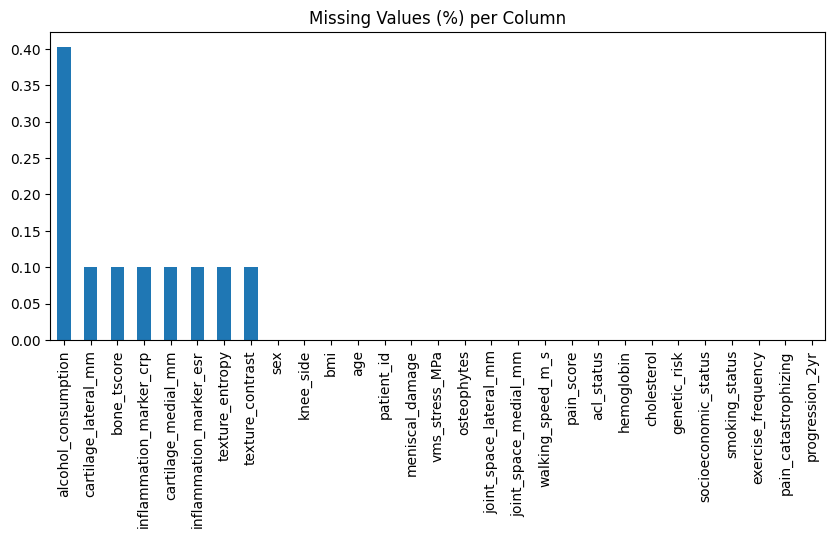

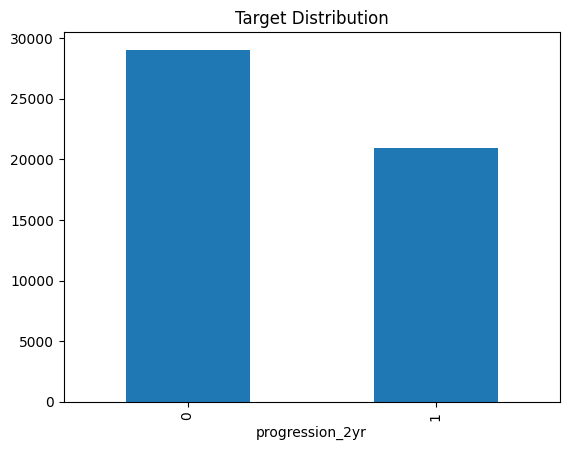

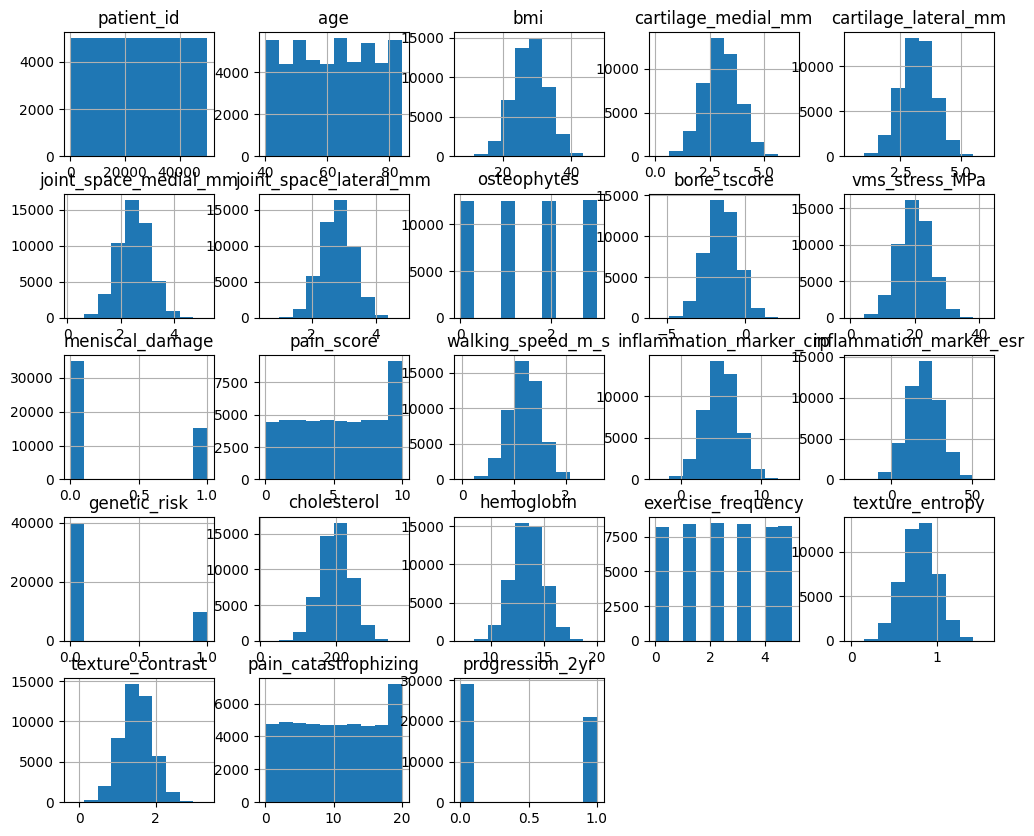

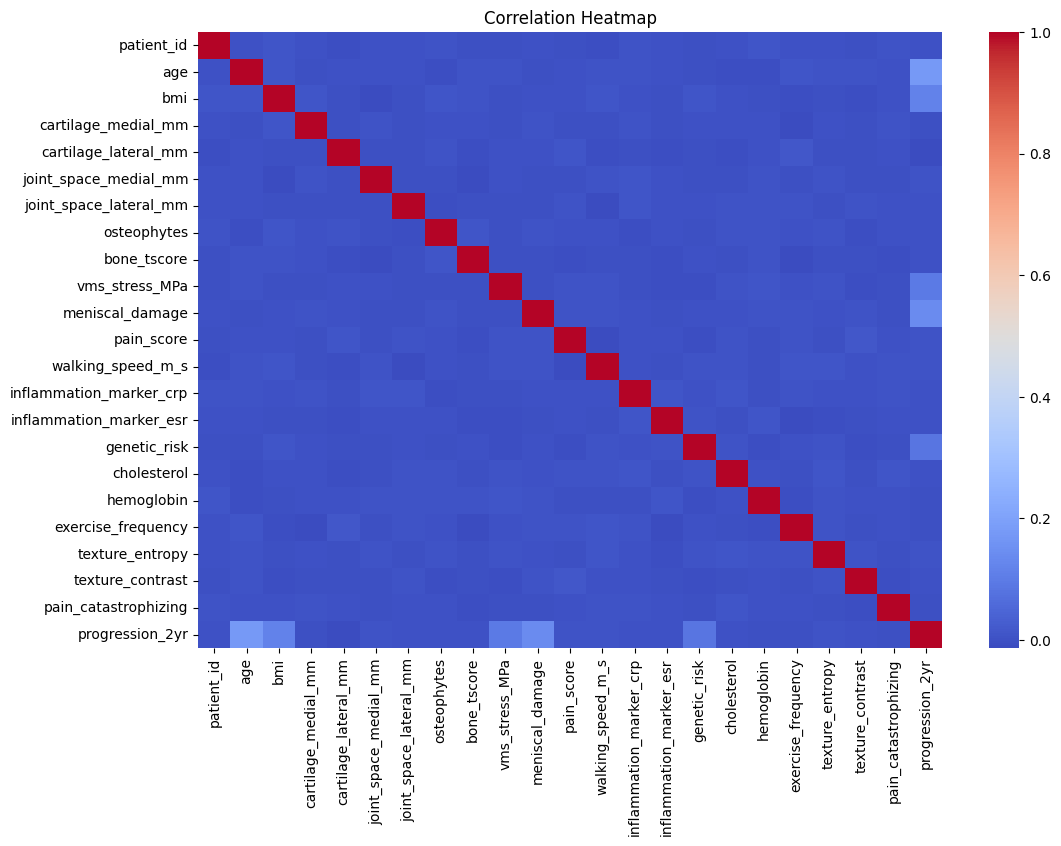

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

assert df.shape[0] > 0 and df.shape[1] > 0, "Empty dataset"
logger.info(f"Dataset shape: {df.shape}")

print(df.shape)
print(df.info())
print(df.describe())

# Missing values
df.isnull().sum().sort_values(ascending=False).head()

plt.figure(figsize=(10,4))
df.isnull().mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Missing Values (%) per Column")
plt.show()

# Class balance
df['progression_2yr'].value_counts().plot(kind="bar")
plt.title("Target Distribution")
plt.show()

# Numeric distributions
df.select_dtypes(include='number').hist(figsize=(12,10))
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


### **Data Cleaning**

In [4]:
# Remove duplicates
df = df.drop_duplicates()

# Select target
target = 'progression_2yr'
X = df.drop(columns=[target, 'patient_id'])
y = df[target].astype(int)

# Numeric & categorical columns



### **Preprocessing step**

In [8]:
target = 'progression_2yr'
X = df.drop(columns=[target, 'patient_id'])
y = df[target].astype(int)


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
logger.info(f'Training shape : {X_train.shape} Testing shape : {X_test.shape}')


numeric_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", cat_pipeline, cat_cols)
])


### **Model loop**

In [9]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=2000, solver="saga"),
        "params": {"model__C": [10]}
    },
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {"model__n_estimators": [5,10], "model__max_depth": [1,10]}
    },
    "HistBoost": {
        "model": HistGradientBoostingClassifier(),
        "params": {"model__max_iter": [100], "model__max_depth": [10]}
    }
}

results = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, mp in models.items():
    pipe = ImbPipeline([
        ("preproc", preprocessor),
        ("smote", SMOTE()),
        ("model", mp["model"])
    ])

    grid = GridSearchCV(pipe, mp["params"], cv=skf, scoring="f1", n_jobs=-1)
    grid.fit(X, y)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X)
    y_proba = best_model.predict_proba(X)[:,1]

    results[name] = {
        "model": best_model,
        "f1": f1_score(y, y_pred),
        "roc": roc_auc_score(y, y_proba)
    }

    print(f"{name} = {results[name]}")


LogisticRegression = {'model': Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'cartilage_medial_mm',
                                                   'cartilage_lateral_mm',
                                                   'joint_space_medial_mm',
                                                   'joint_space_la

### **ROC & PR Curves**

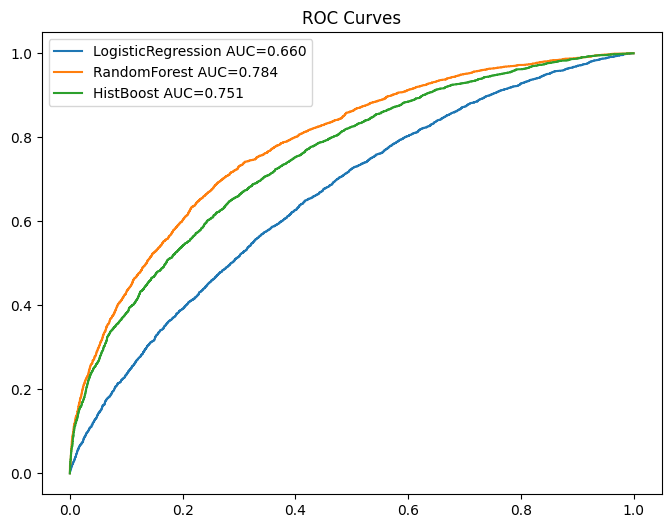

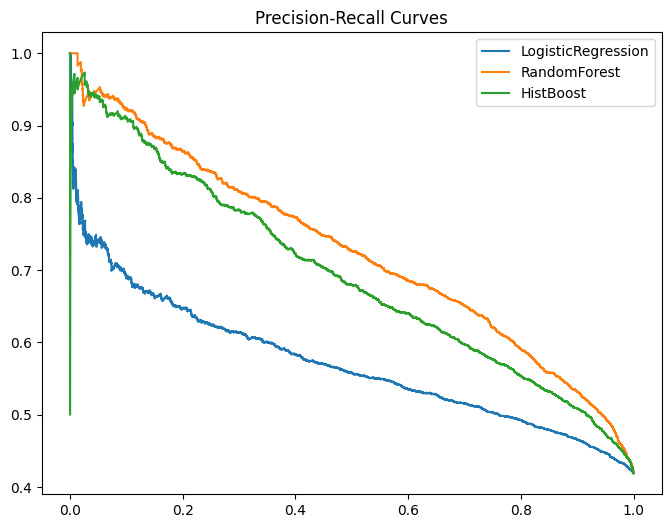

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
for name in results:
    model = results[name]["model"]
    probs = model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, probs)
    auc_val = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} AUC={auc_val:.3f}")
plt.legend()
plt.title("ROC Curves")
plt.show()

plt.figure(figsize=(8,6))
for name in results:
    probs = results[name]["model"].predict_proba(X_test)[:,1]
    prec, rec,_ = precision_recall_curve(y_test, probs)
    plt.plot(rec, prec, label=name)
plt.legend()
plt.title("Precision-Recall Curves")
plt.show()


### **Model Comparison Table**

In [ ]:
comparison = pd.DataFrame(results).T
comparison = comparison[['acc','f1','roc','prec','rec','cv_f1_mean']]
print("MODEL COMPARISON:\n")
print(comparison)

comparison.to_csv("model_comparison.csv")


### **Feature Importance (RF Only)**

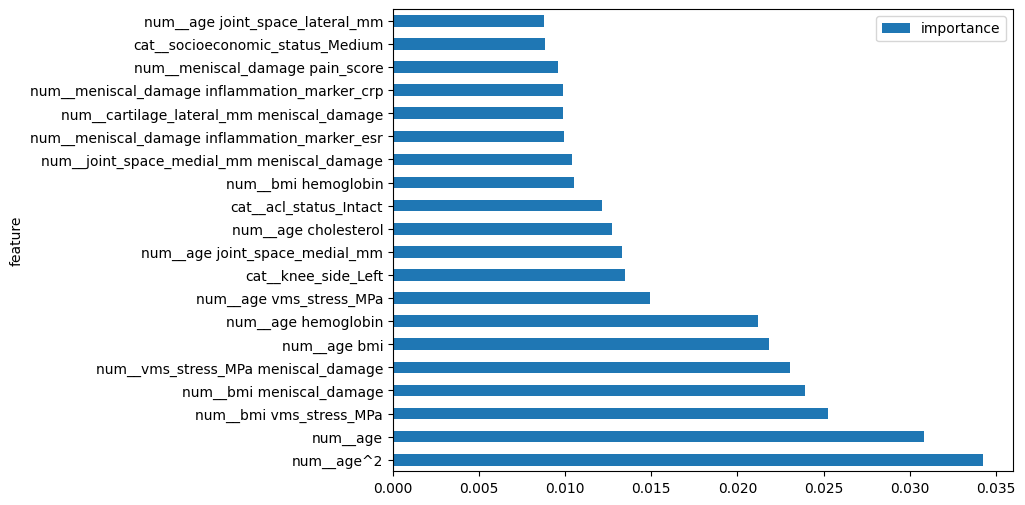

In [11]:
rf = results["RandomForest"]["model"]
feat_names = rf.named_steps["preproc"].get_feature_names_out()
importances = rf.named_steps["model"].feature_importances_

pd.DataFrame({"feature":feat_names,"importance":importances})\
  .sort_values("importance",ascending=False).head(20).plot(
      x="feature", y="importance", kind="barh", figsize=(8,6))
plt.show()


### **Save Best Model Predictions**

In [12]:
best_model_name = max(results, key=lambda x: results[x]["roc"])
print("Best model:", best_model_name)

final_model = results[best_model_name]["model"]

preds = X.copy()
preds["y_pred"] = final_model.predict(X)
preds["y_proba"] = final_model.predict_proba(X)[:,1]

preds.to_csv("predictions.csv", index=False)
files.download("predictions.csv")


Best model: RandomForest


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>